## DB접속 & 데이터 저장

In [1]:
import pymysql

# Mysql DB 접속
iscream_questions = pymysql.connect(
    user='root', 
    passwd='', 
    host='192.168.1.30', 
    db='iscream_questions', 
    charset='utf8'
)

cursor = iscream_questions.cursor(pymysql.cursors.DictCursor)

sql = "SELECT question_id, body_html, list_html, explanation_html FROM questions_78786\
        UNION\
        SELECT question_id, body_html, list_html, explanation_html FROM questions_120562 WHERE etc_category1 LIKE '%중학교 1학년%'\
        UNION\
        SELECT question_id, body_html, list_html, explanation_html FROM questions_120562 WHERE etc_category1 LIKE '%중학교 2학년%'\
        UNION\
        SELECT question_id, body_html, list_html, explanation_html FROM questions_120562 WHERE etc_category1 LIKE '%중학교 3학년%'\
        UNION\
        SELECT question_id, body_html, list_html, explanation_html FROM questions_120562 WHERE etc_category1='이관' AND body_title_html NOT regexp('①|더미')"

cursor.execute(sql)
mysql_result = cursor.fetchall()

question_id_list = []
body_html_list = []
list_html_list = []
explanation_html_list = []

for i in mysql_result:
    question_id_list.append(i['question_id'])
    body_html_list.append(i['body_html'])
    list_html_list.append(i['list_html'])
    explanation_html_list.append(i['explanation_html'])
    
# print(question_id_list)
# print(body_html_list)
# print(list_html_list)
# print(explanation_html_list)

In [2]:
print(len(body_html_list))

103429


## 테이블 포함된 문항 체크

In [ ]:
# import re

# tr_list = []
# for i in range(len(body_html_list)):
#     a = re.search("<tr>", body_html_list[i])
#     if a!=None:
#         tr_list.append(i)

# # len(tr_list)
# # tr_list

## 제거문항 인덱스 합치기

In [ ]:
# remove_list = list(set(tr_list + scoring_list))

# len(remove_list)

## HTML 태그 제거

In [2]:
# html 태그 제거
def removetag(list_name):
    
    import re
    
    list_modify = []
    for i in range(len(list_name)):
        list_name[i]=re.sub('<.+?>', '', list_name[i], 0).strip()
        list_name[i] = list_name[i].replace("$$", "")
        list_name[i] = list_name[i].replace("\\hspace{1.2pt}", "")
        list_name[i] = list_name[i].replace("&nbsp;", "")
        list_name[i] = list_name[i].replace("[#NO#]", "")
        list_name[i] = list_name[i].replace("\n", "")
        list_name[i] = list_name[i].replace("\t", "")
        list_name[i] = list_name[i].replace("&lt;", " ")
        list_name[i] = list_name[i].replace("&gt;", " ")
        list_name[i] = list_name[i].replace("•", "")
        list_name[i] = list_name[i].replace("\r", "")
        list_name[i] = list_name[i].replace("　", "") # \u3000 제거
        list_name[i] = list_name[i].replace("문제시작/", "")
        list_name[i] = list_name[i].replace("해설시작/", "")
#         list_name[i] = list_name[i].replace("■▣", "")
#         list_name[i] = list_name[i].replace("", "")
        list_name[i] = list_name[i].strip()
        
        # 배점, 채점기준 내용 제거
        a = re.search("배점", list_name[i])
        if a!=None:
            list_name[i] = list_name[i].split("배점")[0]
        
        list_modify.append(list_name[i])
    
    return list_modify

body_html_list_modify = removetag(body_html_list)
list_html_list_modify = removetag(list_html_list)
explanation_html_list_modify = removetag(explanation_html_list)

# body_html_list_modify
# list_html_list_modify
# explanation_html_list_modify

## 텍스트 파일로 저장

In [5]:
# txt파일 생성
def createtxt(list_name):
    
    import datetime
    
    basename = "createtxt"
    suffix = datetime.datetime.now().strftime("%y%m%d_%H%M%S")
    filename = "_".join([basename, suffix])
    
    f = open('{}.txt'.format(filename), 'w', encoding='utf-8')
    
    for i in range(len(list_name)):
        f.write('%s\n' %list_name[i])
    f.close()

# createtxt(body_html_list_modify)
# createtxt(list_html_list_modify)
# createtxt(explanation_html_list_modify)

## 문항 제거

In [ ]:
total_list_removed = []

for i in range(len(total_list)):
    
    if i in remove_list:
        continue
    total_list_removed.append(total_list[i])
    
print(len(total_list_removed))

## 텍스트에서 데이터 불러오기(테그 제거 완료)

In [3]:
# body_html_list_modify = []
# list_html_list_modify = []
# explanation_html_list_modify = []

# with open("./questions/body_html.txt", mode = 'r', encoding='UTF-8') as f:
#     for line in f:
#         body_html_list_modify.append(line)

# f.close()

# with open("./questions/list_html.txt", mode = 'r', encoding='UTF-8') as f:
#     for line in f:
#         list_html_list_modify.append(line)

# f.close()

# with open("./questions/explanation_html.txt", mode = 'r', encoding='UTF-8') as f:
#     for line in f:
#         explanation_html_list_modify.append(line)

# f.close()

## 문제, 선지, 해설 합치기

In [3]:
total_list = []

for i in range(len(body_html_list_modify)):
    total_list.append(body_html_list_modify[i] + " " + list_html_list_modify[i] + " " + explanation_html_list_modify[i])

print(len(total_list))

103429


In [4]:
total_list_removed = total_list

## MeCab - 특정 태그 저장

In [5]:
import time
from tqdm import tqdm
import random
import MeCab

init_result = []
# init_no_result = []
result = []
# no_result = []

t = MeCab.Tagger ('-d C:/mecab/mecab-ko-dic')

for j in tqdm(range(len(total_list_removed))):
    sentence = total_list_removed[j]
    tokenlist=t.parse(sentence)

    m = tokenlist.split("\n")
    m.remove('')
    m.remove('EOS')

    word_list = []
#     pumsa_list = []
    for i in range(len(m)):
        m1 = m[i].split('\t')[0]
        m2 = m[i].split('\t')[1].split(',')[0]

        if m2 in ["NNG","NNP"]:
            word_list.append(m1)
#             pumsa_list.append(m2)
    if word_list:
        result.append(word_list)
        init_result.append(total_list_removed[j])
    if not word_list:
        result.append(' ')
        init_result.append(total_list_removed[j])

len(result)

100%|██████████████████████████████████████████████████████████████████████████████████| 103429/103429 [00:25<00:00, 4023.96it/s]


103429

In [8]:
result[61360]
init_result[61360]
# for i in range(len(no_result)):
#     print(total_list_removed[no_result[i]])

'두 이차방정식   ( {x}  -  {1} ) ( {x}  -  {2} )  =  0,  ( {x}  -  {2} ) ( {x}  -  {3} )  =  {0}  을모두 만족시키는   {x}   의 값은? {2}    {3} ( {x}  -  {1} ) ( {x}  -  {2} )  =  {0}  의 근 :   {x}  =  {1}   또는   {x}  =  {2}    ( {x}  -  {2} ) ( {x}  -  {3} )  =  {0}  의 근 :   {x}  =  {2}   또는   {x}  =  {3}  따라서 두 방정식을 모두 만족시키는   {x}   의 값은 공통으로 만족하는   {x}  =  {2}'

## 원본 문항에서 특정 단어 포함하는 인덱스 찾기

In [8]:
text = "일차방정식"
spec_index_list_ori = []
spec_index_list = []
for i in range(len(total_list_removed)):
    if text in total_list_removed[i]:
        spec_index_list_ori.append(i)
print(len(spec_index_list_ori))
for i in range(len(result)):
    if text in result[i]:
        spec_index_list.append(i)
print(len(spec_index_list))
for i in range(len(spec_index_list_ori)):
    if spec_index_list_ori[i] not in spec_index_list:
        print(spec_index_list_ori[i])
        

1443
1443


## 테스트 - 특정 문항 태그분석

In [9]:
import time
from tqdm import tqdm
import random
import MeCab

# phrase = random.sample(total_list_removed,1)
phrase = total_list_removed[61360]
# phrase = "이차방정식을 계산한 것입니다."

t = MeCab.Tagger ('-d C:/mecab/mecab-ko-dic')
tokenlist=t.parse(phrase)

m = tokenlist.split("\n")
m.remove('')
m.remove('EOS')

result_one = []
for i in range(len(m)):
    m1 = m[i].split('\t')[0]
    m2 = m[i].split('\t')[1].split(',')[0]
    m3 = m1 + " : " + m2
    result_one.append(m3)
    
result_one

['두 : MM',
 '이차방정식 : NNP',
 '( : SSO',
 '{ : SY',
 'x : SL',
 '} : SY',
 '- : SY',
 '{ : SY',
 '1 : SN',
 '} : SY',
 ') : SY',
 '( : SY',
 '{ : SY',
 'x : SL',
 '} : SY',
 '- : SY',
 '{ : SY',
 '2 : SN',
 '} : SY',
 ') : SY',
 '= : SY',
 '0 : SN',
 ', : SC',
 '( : SY',
 '{ : SY',
 'x : SL',
 '} : SY',
 '- : SY',
 '{ : SY',
 '2 : SN',
 '} : SY',
 ') : SY',
 '( : SY',
 '{ : SY',
 'x : SL',
 '} : SY',
 '- : SY',
 '{ : SY',
 '3 : SN',
 '} : SY',
 ') : SY',
 '= : SY',
 '{ : SY',
 '0 : SN',
 '} : SY',
 '을 : JKO',
 '모두 : MAG',
 '만족 : NNG',
 '시키 : XSV',
 '는 : ETM',
 '{ : SY',
 'x : SL',
 '} : SY',
 '의 : NNG',
 '값 : NNG',
 '은 : JX',
 '? : SY',
 '{ : SY',
 '2 : SN',
 '} : SY',
 '{ : SY',
 '3 : SN',
 '} : SY',
 '( : SY',
 '{ : SY',
 'x : SL',
 '} : SY',
 '- : SY',
 '{ : SY',
 '1 : SN',
 '} : SY',
 ') : SY',
 '( : SY',
 '{ : SY',
 'x : SL',
 '} : SY',
 '- : SY',
 '{ : SY',
 '2 : SN',
 '} : SY',
 ') : SY',
 '= : SY',
 '{ : SY',
 '0 : SN',
 '} : SY',
 '의 : NNG',
 '근 : NNG',
 ': : SC',
 '{ : SY',
 'x

### eunjeon mecab

In [ ]:
# import time
# from tqdm import tqdm
# import random

# sentence = total_list_remove_table

# from eunjeon import mecab

# result = []

# start_time = time.time()

# for i in tqdm(range(len(sentence))):
    
#     input_str = sentence[i]
#     tokenlist=t.parse(sentence)
    
#     temp=[]
#     for word in tokenlist:
#         if word[1] in ["NNP","NNG"]: 
#             temp.append((word[0]))
    
#     if temp: # 이번에 읽은 데이터에 명사가 존재할 경우에만
#         result.append(temp) # 결과에 저장

# end_time = time.time()
# print(end_time - start_time)

## 텍스트 파일로 결과 저장

In [ ]:
def write_txt(list, fname, sep):
    file = open(fname, 'w', encoding='UTF-8')
    vstr = ""
    
    for i in list:
        for j in i:
            vstr = vstr + str(j) + sep
        vstr = vstr.rstrip(sep) # 마지막에 추가되는 sep 삭제
        vstr = vstr + '\n'

    file.writelines(vstr) # 한 라인씩 저장
    
    file.close()
    
# result_1000 = random.sample(result,1000)
# write_txt(result_1000, "result_1000_VA.txt", ",")

## 모델 생성

In [ ]:
# import logging

# logging.basicConfig(
#     format='%(asctime)s - %(levelname)s - %(message)s', 
#     level=logging.INFO)

In [10]:
from gensim.models import Word2Vec

model = Word2Vec(result, 
                 size=85,          # 차원
                 window=5,         # 앞뒤 고려 단어수
                 min_count=10,     # 최소 중복 개수
                 workers=4,        # CPU 코어
                 sg=1,             # CBOW / Skip-Gram
                 iter = 5,         # iteration
                 sample = 0.001)   # 빈번하게 등장하는 단어 다운샘플링

model.init_sims(replace=True)

In [9]:
model.wv.get_vector('테스트')

NameError: name 'model' is not defined

In [11]:
model.wv.most_similar(positive="이차방정식", topn=5)

[('근', 0.8845056295394897),
 ('중근', 0.8666121363639832),
 ('근일', 0.8510861396789551),
 ('판별식', 0.7983155846595764),
 ('전개식', 0.7656952142715454)]

In [12]:
vocab = list(model.wv.vocab)
vocab

['분수',
 '소수',
 '안',
 '분모',
 '인',
 '후',
 '기약분수',
 '자리',
 '수',
 '분자',
 '최대공약수',
 '기호',
 '크기',
 '비교',
 '다음',
 '소윤',
 '석이',
 '말',
 '조건',
 '만족',
 '지민',
 '규',
 '눈금',
 '칸',
 '오른쪽',
 '왼쪽',
 '곳',
 '선',
 '때',
 '소수점',
 '아래',
 '자릿수',
 '답',
 '어머니',
 '고구마',
 '양',
 '서현',
 '우유',
 '지형',
 '사과',
 '주스',
 '지성',
 '아침',
 '거리',
 '직사각',
 '가로',
 '세로',
 '길이',
 '윤주',
 '하루',
 '동안',
 '물',
 '과',
 '사이',
 '자연수',
 '막대',
 '순서',
 '이면',
 '셈식',
 '곱',
 '색칠',
 '부분',
 '계산',
 '방법',
 '곱셈',
 '이용',
 '위치',
 '결과',
 '무게',
 '책',
 '평행사변형',
 '넓이',
 '밑변',
 '높이',
 '변이',
 '정사각형',
 '둘레',
 '변',
 '선우',
 '몸무게',
 '아빠',
 '배',
 '유라',
 '오빠',
 '수돗물',
 '시간',
 '다희',
 '미소',
 '날',
 '효',
 '부모',
 '여행',
 '건물',
 '층',
 '층수',
 '숫자',
 '카드',
 '사용',
 '나머지',
 '그림',
 '색',
 '테이프',
 '전체',
 '합',
 '가격',
 '얼마',
 '원',
 '직사각형',
 '페트병',
 '주전자',
 '냉장고',
 '당근',
 '포도',
 '진호',
 '집',
 '앞',
 '텃밭',
 '시작',
 '설명',
 '연주',
 '만세',
 '은지',
 '버스',
 '빠르기',
 '반',
 '자동차',
 '차례',
 '키',
 '예진',
 '보람',
 '학생',
 '안경',
 '명',
 '수진',
 '식이',
 '생각',
 '이동',
 '관계',
 '상자',
 '자두',
 '트럭',
 '금',
 '돈',
 '

In [6]:
model.save("total_list.h5")

In [ ]:
# 모델 불러오기
# model = Word2Vec.load('total_list_removed.h5')

In [ ]:
# test_list = ["서로 다른 두 개의 주사위를 동시에 던질 때, 나오는 눈의 수의 곱이 24이상인 경우의 수는?",
#              "두 자연수A, B의 최대공약수가 72일 때, 이 두 수 A,B의 공약수의 개수는?",
#              "두 유리수 17/3과 3/2사이에 있는 정수가 아닌 유리수 중 분모가 5인 기약분수의 개수는?",
#              "방정식 0.7(x-4) = -1-0.9(3-x)의 해를 x=a라 할 때, a보다 작은 자연수의 개수는?",
#              "원가가 3000원인 어떤 물건이 있다. 이 물건을 정가의 20%를 할인하여 팔았더니 원가에 대하여 12%의 이익을 얻었다고 한다. 이 물건은 원가에 몇 %이익을 붙여서 정가를 정한 것인가?",
#              "어떤 3b/2a식에 를 곱해야 할 것을 잘못하여 나누었더니 6ab이 되었다. 바르게 계산한 답은?",
#              "어떤 다항식을 2x^2으로 나누었더니 나누어떨어졌다. 몫이 3x^2-2x-6일 때, 이 다항식의 x^2의 계수는?",
#              "다음 중 문장을 부등식으로 나타낸 것으로 옳지 않은 것은? ① x에서 5를 뺀 수는 x의 3배보다 작다. ② 한 개에 x원인 사과 6의 값은 것은 한 통에 8000원인 수박 한 통의 값보다 싸다. ③ 가로의 길이가 xcm, 세로의 길이가 6cm인 직사각형의 둘레의 길이는  42cm미만이다. ④ 시속 2km로 x시간 동안 달린 거리는 30km이상이다. ⑤ 8명이 각각 x원씩 내면 총액은 30000원 이하이다.",
#              "x=2, y-3이 x,y 에 대한 일차방정식 (2a+b)x-(a-b)y=0의 해일 때, 일차방정식 ax-2b=3by-a를 만족시키는 x,y 에 대하여 5x+3y의 값을 구하시오. (단, a,b 는 상수이고, ab!=0이다.)",
#              "상수 a,b 에 대하여 일차방정식 ax-y-b=0의 그래프가 일차방정식 -4x+2y+5=0의 그래프와 평행하고, 일차방정식 2x+y-1=0의 그래프와 y축 위에서 만난다. 이때 a+b의 값은? (단, a!=0)"
#             ]

## 리스트 문항을 토큰화하고 해당 단어와 유사한 단어 찾기

In [7]:
import numpy as np
from tqdm import tqdm
import random
import MeCab

np.random.seed(1)
test_list = random.sample(total_list, 50)

# 리스트 단어 각각에 대해 가장 유사한 단어 추출
def similar(list):
    token_result = []
    for i in range(len(list)):
        token_result.append(list[i])
        token_result.append(model.wv.most_similar(positive="{}".format(list[i]), topn=1))
    return token_result

# 추출된 단어의 유사도 평균 계산
def mean_similar(list):
    import numpy as np
    
    cosine_value_list = []
    for i in range(len(list)):
        if i%2 !=0:
            cosine_value_list.append(list[i][0][1])
    cosine_value = np.mean(cosine_value_list)
    return cosine_value

'''
random sampling된 test_list의 문항들을 토큰화 하고
모델의 vocab에 있는 명사만 test_result에 저장한다.
similar_list에는 기존명사, top1명사, cosine유사도 값이 들어있다.
'''
def modeltest():
    t = MeCab.Tagger ('-d C:/mecab/mecab-ko-dic')
    vocab = list(model.wv.vocab)

    test_result = []
    no_test_result = []
    for j in range(len(test_list)):
        sentence = test_list[j]
        tokenlist=t.parse(sentence)

        m = tokenlist.split("\n")
        m.remove('')
        m.remove('EOS')

        word_list = []
        for i in range(len(m)):
            m1 = m[i].split('\t')[0]
            m2 = m[i].split('\t')[1].split(',')[0]

            if m2 in ["NNG","NNP"]:
                if m1 in vocab:
                    word_list.append(m1)
        if word_list:
            test_result.append(word_list)
        if not word_list:
            no_test_result.append(j)

    testword_list = []
    for i in range(len(test_result)):
        m = test_result[i]
        for j in range(len(m)):
            testword_list.append(m[j])

    similar_list = similar(testword_list)
    return mean_similar(similar_list)

  5%|████▋                                                                                        | 1/20 [00:06<02:08,  6.74s/it]

size = 25, iter = 5
0.8846097720364864



 10%|█████████▎                                                                                   | 2/20 [00:19<02:31,  8.41s/it]

size = 25, iter = 10
0.8780103574129102



 15%|█████████████▉                                                                               | 3/20 [00:38<03:17, 11.62s/it]

size = 25, iter = 15
0.8718199188867773



 20%|██████████████████▌                                                                          | 4/20 [01:03<04:12, 15.76s/it]

size = 25, iter = 20
0.8679667060216699



 25%|███████████████████████▎                                                                     | 5/20 [01:34<05:06, 20.41s/it]

size = 25, iter = 25
0.8650171208414003



 30%|███████████████████████████▉                                                                 | 6/20 [02:12<05:58, 25.59s/it]

size = 25, iter = 30
0.8624358310628293



 35%|████████████████████████████████▌                                                            | 7/20 [02:54<06:36, 30.47s/it]

size = 25, iter = 35
0.8638079176926063



 40%|█████████████████████████████████████▏                                                       | 8/20 [03:41<07:05, 35.42s/it]

size = 25, iter = 40
0.863798331292384



 45%|█████████████████████████████████████████▊                                                   | 9/20 [04:34<07:27, 40.67s/it]

size = 25, iter = 45
0.8646670987518704



 50%|██████████████████████████████████████████████                                              | 10/20 [05:34<07:43, 46.40s/it]

size = 25, iter = 50
0.8625697127190827



 55%|██████████████████████████████████████████████████▌                                         | 11/20 [06:39<07:48, 52.09s/it]

size = 25, iter = 55
0.8616182774184031



 60%|███████████████████████████████████████████████████████▏                                    | 12/20 [07:50<07:43, 57.91s/it]

size = 25, iter = 60
0.8609281022965989



 65%|███████████████████████████████████████████████████████████▊                                | 13/20 [09:06<07:21, 63.12s/it]

size = 25, iter = 65
0.8661496033500299



 70%|████████████████████████████████████████████████████████████████▍                           | 14/20 [10:26<06:50, 68.39s/it]

size = 25, iter = 70
0.8664932145839469



 75%|█████████████████████████████████████████████████████████████████████                       | 15/20 [11:53<06:08, 73.73s/it]

size = 25, iter = 75
0.8623580087476702



 80%|█████████████████████████████████████████████████████████████████████████▌                  | 16/20 [13:23<05:14, 78.74s/it]

size = 25, iter = 80
0.8620175870496836



 85%|██████████████████████████████████████████████████████████████████████████████▏             | 17/20 [14:59<04:11, 83.91s/it]

size = 25, iter = 85
0.8639559649547696



 90%|██████████████████████████████████████████████████████████████████████████████████▊         | 18/20 [16:40<02:58, 89.14s/it]

size = 25, iter = 90
0.8666605392175257



 95%|███████████████████████████████████████████████████████████████████████████████████████▍    | 19/20 [18:30<01:35, 95.19s/it]

size = 25, iter = 95
0.8606803794081855



100%|████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [20:25<00:00, 61.29s/it]

size = 25, iter = 100
0.8676880873042175


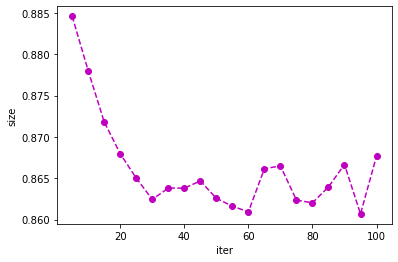

  5%|████▋                                                                                        | 1/20 [00:07<02:19,  7.34s/it]

size = 30, iter = 5
0.8691310780666253



 10%|█████████▎                                                                                   | 2/20 [00:20<02:45,  9.21s/it]

size = 30, iter = 10
0.8578272286393103



 15%|█████████████▉                                                                               | 3/20 [00:41<03:34, 12.61s/it]

size = 30, iter = 15
0.8507644462941298



 20%|██████████████████▌                                                                          | 4/20 [01:08<04:31, 16.99s/it]

size = 30, iter = 20
0.8490906825220892



 25%|███████████████████████▎                                                                     | 5/20 [01:42<05:28, 21.90s/it]

size = 30, iter = 25
0.8495156339583274



 30%|███████████████████████████▉                                                                 | 6/20 [02:21<06:20, 27.16s/it]

size = 30, iter = 30
0.8455221704744419



 35%|████████████████████████████████▌                                                            | 7/20 [03:07<07:05, 32.69s/it]

size = 30, iter = 35
0.8460683299372607



 40%|█████████████████████████████████████▏                                                       | 8/20 [03:58<07:39, 38.27s/it]

size = 30, iter = 40
0.8458303874674452



 45%|█████████████████████████████████████████▊                                                   | 9/20 [04:55<08:04, 44.01s/it]

size = 30, iter = 45
0.8446730807160749



 50%|██████████████████████████████████████████████                                              | 10/20 [05:59<08:18, 49.80s/it]

size = 30, iter = 50
0.8458996157147991



 55%|██████████████████████████████████████████████████▌                                         | 11/20 [07:08<08:20, 55.59s/it]

size = 30, iter = 55
0.8466028852572758



 60%|███████████████████████████████████████████████████████▏                                    | 12/20 [08:26<08:18, 62.32s/it]

size = 30, iter = 60
0.8413156207089831


  2%|█▌                                                                                      | 1/56 [28:58<26:33:51, 1738.76s/it]


KeyboardInterrupt: 

In [61]:
%matplotlib inline
from gensim.models import Word2Vec
from tqdm import tqdm
from matplotlib import pyplot as plt

for s in tqdm([100*i for i in range(1,21)]):
    x = []
    y = []
    for i in tqdm([5*i for i in range(1,21)]):
        model = Word2Vec(result, size=s, window=5, min_count=10, workers=4, sg=1, iter=i)
        cos = modeltest()
        print("size = %d, iter = %d" % (s, i))
        print(cos)
        x.append(i)
        y.append(cos)
        model.init_sims(replace=True)
    plt.plot(x, y, c='m', ls='--', marker='o')
    plt.xlabel('iter')
    plt.ylabel('cos')
    plt.show()

  2%|██▎                                                                                          | 1/40 [00:05<03:22,  5.18s/it]

size = 5
0.9949614356609923


  5%|████▋                                                                                        | 2/40 [00:10<03:21,  5.31s/it]

size = 10
0.9533176491372579


  8%|██████▉                                                                                      | 3/40 [00:16<03:24,  5.53s/it]

size = 15
0.9223858553809223


 10%|█████████▎                                                                                   | 4/40 [00:23<03:30,  5.86s/it]

size = 20
0.899885826571492


 12%|███████████▋                                                                                 | 5/40 [00:30<03:37,  6.23s/it]

size = 25
0.8759758200097645


 15%|█████████████▉                                                                               | 6/40 [00:38<03:45,  6.64s/it]

size = 30
0.8650687388278174


 18%|████████████████▎                                                                            | 7/40 [00:44<03:33,  6.46s/it]

size = 35
0.8511120719791393


 20%|██████████████████▌                                                                          | 8/40 [00:50<03:24,  6.38s/it]

size = 40
0.8347196415572503


 22%|████████████████████▉                                                                        | 9/40 [00:57<03:20,  6.47s/it]

size = 45
0.8166029988630011


 25%|███████████████████████                                                                     | 10/40 [01:04<03:19,  6.64s/it]

size = 50
0.8062261958501981


 28%|█████████████████████████▎                                                                  | 11/40 [01:11<03:21,  6.96s/it]

size = 55
0.7943486635896618


 30%|███████████████████████████▌                                                                | 12/40 [01:19<03:24,  7.31s/it]

size = 60
0.7812279712593586


 32%|█████████████████████████████▉                                                              | 13/40 [01:26<03:09,  7.00s/it]

size = 65
0.7728037868405135


 35%|████████████████████████████████▏                                                           | 14/40 [01:32<02:57,  6.84s/it]

size = 70
0.7665467893330298


 38%|██████████████████████████████████▌                                                         | 15/40 [01:39<02:50,  6.81s/it]

size = 75
0.7582790637607674


 40%|████████████████████████████████████▊                                                       | 16/40 [01:46<02:44,  6.87s/it]

size = 80
0.753173613361528


 42%|███████████████████████████████████████                                                     | 17/40 [01:54<02:42,  7.09s/it]

size = 85
0.744606790436777


 45%|█████████████████████████████████████████▍                                                  | 18/40 [02:02<02:42,  7.37s/it]

size = 90
0.7355913013297646


 48%|███████████████████████████████████████████▋                                                | 19/40 [02:11<02:44,  7.85s/it]

size = 95
0.7287972508771613


 50%|██████████████████████████████████████████████                                              | 20/40 [02:18<02:32,  7.61s/it]

size = 100
0.7218320460372432


 52%|████████████████████████████████████████████████▎                                           | 21/40 [02:25<02:23,  7.54s/it]

size = 105
0.7141419137893706


 55%|██████████████████████████████████████████████████▌                                         | 22/40 [02:33<02:16,  7.57s/it]

size = 110
0.7123853560760812


 57%|████████████████████████████████████████████████████▉                                       | 23/40 [02:40<02:10,  7.66s/it]

size = 115
0.7060528390556963


 60%|███████████████████████████████████████████████████████▏                                    | 24/40 [02:49<02:04,  7.80s/it]

size = 120
0.7011769445851328


 62%|█████████████████████████████████████████████████████████▌                                  | 25/40 [02:57<02:01,  8.08s/it]

size = 125
0.6998180113635549


 65%|███████████████████████████████████████████████████████████▊                                | 26/40 [03:04<01:48,  7.78s/it]

size = 130
0.6918665969418484


 68%|██████████████████████████████████████████████████████████████                              | 27/40 [03:12<01:39,  7.67s/it]

size = 135
0.6907403849979605


 70%|████████████████████████████████████████████████████████████████▍                           | 28/40 [03:19<01:31,  7.60s/it]

size = 140
0.6921192335631144


 72%|██████████████████████████████████████████████████████████████████▋                         | 29/40 [03:27<01:24,  7.72s/it]

size = 145
0.6913894624996434


 75%|█████████████████████████████████████████████████████████████████████                       | 30/40 [03:36<01:19,  7.97s/it]

size = 150
0.6856849991154733


 78%|███████████████████████████████████████████████████████████████████████▎                    | 31/40 [03:45<01:14,  8.24s/it]

size = 155
0.6869990670416436


 80%|█████████████████████████████████████████████████████████████████████████▌                  | 32/40 [03:52<01:03,  7.88s/it]

size = 160
0.685873258246143


 82%|███████████████████████████████████████████████████████████████████████████▉                | 33/40 [03:59<00:54,  7.83s/it]

size = 165
0.686880393571393


 85%|██████████████████████████████████████████████████████████████████████████████▏             | 34/40 [04:07<00:46,  7.81s/it]

size = 170
0.6877193154460768


 88%|████████████████████████████████████████████████████████████████████████████████▌           | 35/40 [04:15<00:39,  7.93s/it]

size = 175
0.6877226561074469


 90%|██████████████████████████████████████████████████████████████████████████████████▊         | 36/40 [04:24<00:32,  8.08s/it]

size = 180
0.6857813765190289


 92%|█████████████████████████████████████████████████████████████████████████████████████       | 37/40 [04:33<00:25,  8.38s/it]

size = 185
0.6797151087002716


 95%|███████████████████████████████████████████████████████████████████████████████████████▍    | 38/40 [04:42<00:17,  8.69s/it]

size = 190
0.681267385499907


 98%|█████████████████████████████████████████████████████████████████████████████████████████▋  | 39/40 [04:50<00:08,  8.46s/it]

size = 195
0.681806655761156


100%|████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [04:58<00:00,  7.47s/it]

size = 200
0.6792862664703911


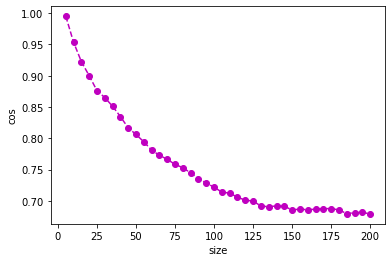

In [13]:
%matplotlib inline
from gensim.models import Word2Vec
from tqdm import tqdm
from matplotlib import pyplot as plt

x = []
y = []
for s in tqdm([5*i for i in range(1,41)]):
    model = Word2Vec(result, size=s, window=5, min_count=10, workers=4, sg=1, iter=5, sample=0.001)
    cos = modeltest()
    print("size = %d" % s)
    print(cos)
    x.append(s)
    y.append(cos)
    model.init_sims(replace=True)
plt.plot(x, y, c='m', ls='--', marker='o')
plt.xlabel('size')
plt.ylabel('cos')
plt.show()

In [12]:
y

[0.9951232993882879,
 0.9535192213077147,
 0.9243955578723091,
 0.8995977305556713,
 0.879223353090859,
 0.8631892523317362,
 0.845455129292864,
 0.8324474170220427,
 0.8185611718939739,
 0.807150481886403,
 0.7939413459898598,
 0.7827848004610046,
 0.7754851196048776,
 0.7665681279514851,
 0.7579359461604459,
 0.748238581278928,
 0.738639483408268,
 0.7363662107339416,
 0.7284979828810879,
 0.7185318789033914,
 0.7162147702809725,
 0.7067181778483229,
 0.7086173507236625,
 0.6981396296550337,
 0.6957361840937218,
 0.6965063726310631,
 0.6940260333040675,
 0.689872028777867,
 0.6895574241020661,
 0.687967429973438,
 0.6855626350983627,
 0.6816648007917653,
 0.6874846528544438,
 0.6830412682058294,
 0.6838497086853644,
 0.6826923074439051,
 0.6849838418997921,
 0.6792981575970238,
 0.6822279539572041,
 0.6818182505375412]

## 시각화

In [ ]:
from sklearn.manifold import TSNE
import matplotlib
import matplotlib.pyplot as plt
import gensim 
import gensim.models as g

vocab = list(model.wv.vocab)
X = model[vocab]

print(len(X))
tsne = TSNE(n_components=2)

# 100개의 단어에 대해서만 시각화
X_tsne = tsne.fit_transform(X[:100,:])
# X_tsne = tsne.fit_transform(X)

In [ ]:
import pandas as pd

df = pd.DataFrame(X_tsne, index=vocab[:len(X_tsne)], columns=['x', 'y'])
df.shape

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# 폰트 설정
import matplotlib.font_manager as fm

path = 'C:/Windows/Fonts/NGULIM.TTF'
font_name = fm.FontProperties(fname=path, size=30).get_name()
print(font_name)
plt.rc('font', family=font_name)

# 그래프에서 마이너스 폰트 깨지는 문제 해결
matplotlib.rcParams['axes.unicode_minus'] = False

%matplotlib inline

fig = plt.figure()
fig.set_size_inches(40, 20)
ax = fig.add_subplot(1, 1, 1)

ax.scatter(df['x'], df['y'])

for word, pos in df.iterrows():
    ax.annotate(word, pos, fontsize=20)
plt.show()